In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as spf

In [2]:
spark = SparkSession.builder.appName("anokhin").getOrCreate()

In [3]:
spark

## User-based Collaborative Filtering

### Собираем данные на Spark и сохраняем как pandas dataframe

In [4]:
data = (
    spark.read.json("/user/anokhin/week03/*/")
        .select(spf.col("user"), spf.col("time"), spf.col("recommendation").cast("int").alias("track"))
        .filter(spf.col("track").isNotNull())
        .groupBy(["user", "track"])
        .agg(
            spf.avg("time").alias("time")
        )
).toPandas()

data.head()

,user,track,time
0,4743,42920,1.00
1,8448,48653,0.01
2,5505,8369,0.00
3,1617,22821,0.05
4,4764,33723,0.63


In [6]:
data.to_json("/home/anokhin/data/week03.json", orient="records", lines=True)

### Готовим рекомендации для каждого пользователя

Рекомендовать пользователю треки, которые понравились похожим на него пользователям

$$\hat r_{ui} = h^{-1} \left( \frac{\sum_{v \in N_i(u)} w_{uv} h(r_{vi})}{\sum_{v \in N_i(u)} w_{uv}} \right)$$

$N_i(u)$ - соседи пользователя $u$, которые оценили айтем $i$,
$w_{uv}, w_{ij}$ - веса соседей, 
$h$ - функция нормализации



**Нормализация**: Номализуем так, чтобы вектор пользователя имел единичную длину

**Веса**: Похожих пользователей будем искать по *cosine similarity*

**Соседи**: в качестве соседей будем рассматривать всех пользователей. Q: Как это упростит формулу?

In [48]:
import tqdm
import json

import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as pl
import seaborn as sns

In [4]:
data = pd.read_json("/Users/n.anokhin/Desktop/week03.json", lines=True)

data.head()

,user,track,time
0,4743,42920,1.00
1,8448,48653,0.01
2,5505,8369,0.00
3,1617,22821,0.05
4,4764,33723,0.63


In [9]:
data["normalized_time"] = data.groupby("user")["time"].transform(lambda time: time / np.sqrt(np.sum(time * time)))

data.head()

,user,track,time,normalized_time
0,4743,42920,1.00,0.301639
1,8448,48653,0.01,0.003725
2,5505,8369,0.00,0.000000
3,1617,22821,0.05,0.011289
4,4764,33723,0.63,0.107738


In [12]:
interactions = pd.pivot_table(data, values="normalized_time", index="user", columns="track").fillna(0)

print("Interactions matrix: \nshape=" + str(interactions.shape))
print("Sparsity=" + str((interactions != 0).values.sum() / interactions.size))

interactions.head()

Interactions matrix: 
shape=(10000, 49980)
Sparsity=0.0006736814725890356


In [13]:
similarity_matrix = cosine_similarity(interactions) #Q: Размер?
np.fill_diagonal(similarity_matrix, 0) #Q: Зачем?

print("Mean positive neighbours per user=" + str((similarity_matrix > 0).sum(axis=1).mean()))
print("Mean negative neighbours per user=" + str((similarity_matrix < 0).sum(axis=1).mean()))

Mean positive neighbours per user=236.2318
Mean negative neighbours per user=0.0


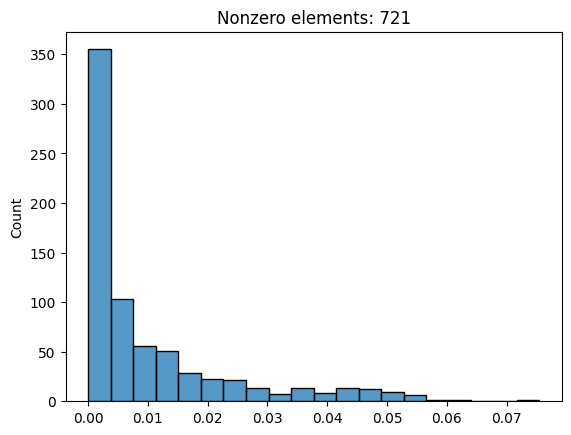

In [53]:
user = 1337

figure, ax = pl.subplots()
sns.histplot(similarity_matrix[user][similarity_matrix[user] > 0], bins=20, ax=ax)

ax.set_title(f"Nonzero elements: " + str((similarity_matrix[user] > 0).sum()))

pass

In [32]:
# TODO: expected size: observed users x observed tracks
scores_matrix = np.matmul(similarity_matrix, interactions.values)

scores = pd.DataFrame(
    scores_matrix,
    index=interactions.index,
    columns=interactions.columns
)

scores[[1, 2, 3, 4, 5]].head()

track,1,2,3,4,5
user,,,,,
0,0.014666,0.0,0.006857,0.000973,0.000000
1,0.000000,0.0,0.000000,0.000000,0.000000
2,0.003316,0.0,0.000000,0.000000,0.024739
3,0.000000,0.0,0.000000,0.000000,0.000000
4,0.000000,0.0,0.000000,0.000000,0.000278


#### Глянем на рекомендации

In [33]:
BOTIFY_DATA_DIR = "/Users/n.anokhin/Projects/recsys-course/botify/data/"

In [43]:
tracks = pd.read_json(BOTIFY_DATA_DIR + "tracks.json", lines=True).set_index("track")
tracks.head()

,artist,title,genre,pop
track,,,,
7,Harmonia,Sehr kosmisch,Pop_Rock,65688
0,Björk,Undo,None,57660
2,Dwight Yoakam,You're The One,Country,55035
1,Florence + The Machine,Dog Days Are Over (Radio Edit),None,52773
15,Kings Of Leon,Revelry,Pop_Rock,48290


In [41]:
user = np.random.choice(scores.index)
k = 10

# data[data["user"] == user].sort_values("time").tail(10)

,user,track,time,normalized_time
468950,1634,38672,0.023333,0.009735
17053,1634,17969,0.160000,0.066755
151849,1634,6883,0.170000,0.070927
57366,1634,1399,0.220000,0.091788
183962,1634,39649,0.800000,0.333773
441073,1634,42434,1.000000,0.417216
281638,1634,23144,1.000000,0.417216
238585,1634,24310,1.000000,0.417216
359903,1634,24527,1.000000,0.417216
470408,1634,21713,1.000000,0.417216


In [44]:
user_scores = pd.merge(
    scores.loc[user].sort_values(ascending=False)[:k].to_frame("score"),
    tracks, 
    left_index=True, 
    right_index=True,
    how="inner"
)

user_scores

,score,artist,title,genre,pop
track,,,,,
21713,0.146096,The Gathering,Adrenaline,None,214
24527,0.133736,Steppenwolf,Don't Step On The Grass_ Sam,None,67
42434,0.097072,Shawn McDonald,Lovely,None,72
29532,0.055959,Jazzanova,L:O.V.E and you & I,Electronic,109
2465,0.051681,Gorillaz,We Are Happy Landfill,None,213
20899,0.051681,Deep Purple,Call Of The Wild,None,337
14337,0.051681,Ace of Base,The Sign,None,974
6754,0.051681,Incubus,Drive,Pop_Rock,5458
24631,0.051681,Ray LaMontagne,All The Wild Horses,Pop_Rock,669


In [45]:
user_interactions = pd.merge(
    interactions.loc[user].sort_values(ascending=False).to_frame("time"),
    tracks, 
    left_index=True, 
    right_index=True, 
    how="inner"
)

user_interactions[user_interactions["time"] != 0]

,time,artist,title,genre,pop
track,,,,,
23144,0.417216,New Grass Revival,Metric Lips,None,180
42434,0.417216,Shawn McDonald,Lovely,None,72
24527,0.417216,Steppenwolf,Don't Step On The Grass_ Sam,None,67
21713,0.417216,The Gathering,Adrenaline,None,214
24310,0.417216,Broken Social Scene,Lover's Spit (Redux),None,842
39649,0.333773,The Edgar Winter Group,Frankenstein,None,121
1399,0.091788,Crystal Castles,Baptism,None,1055
6883,0.070927,Ratatat,Bird-Priest,Pop_Rock,289
17969,0.066755,The Charlatans,The Misbegotten,None,174


## Подготавливаем рекомендации для продакшена

In [46]:
def recommend(user_id, scores, k):
    return scores.loc[user_id].sort_values(ascending=False)[:k].index.tolist()

In [47]:
users = data["user"].unique()

with open(BOTIFY_DATA_DIR + "recommendations_ub.json", "w") as rf:
    for user in tqdm.tqdm(users):
        recommendation = {
            "user": int(user),
            "tracks": recommend(user, scores, 100)
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.36it/s]
